In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors


In [387]:
%matplotlib inline

dataset_path  = './input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


## class 분포

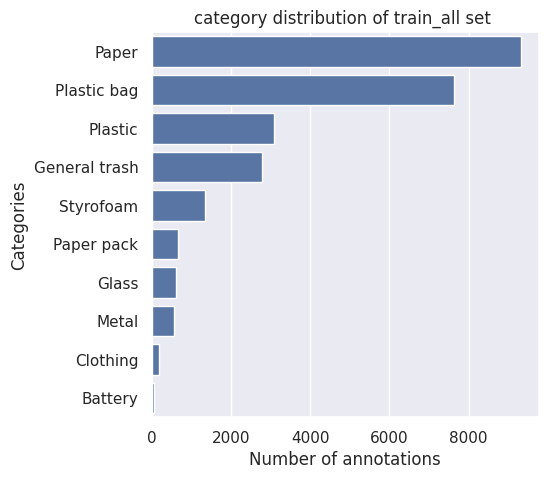

In [4]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [61]:
df

,Categories,Number of annotations
1,Paper,9311
7,Plastic bag,7643
5,Plastic,3090
0,General trash,2782
6,Styrofoam,1343
2,Paper pack,659
4,Glass,610
3,Metal,562
9,Clothing,177
8,Battery,63


In [16]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
dataset.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

## 한 이미지 당 포함된 class의 개수

In [ ]:
## image_id 3059 -> annotation 존재 x

In [25]:
for i in range(3272):
    if i not in img_id_list:
        print(i)

3059


In [27]:
## 이미지 당 class의 개수 count
classes_per_img = {img_id:0 for img_id in range(len(imgs))}
img_id_list = []
unique_class_in_img=[]
for i in range(len(anns)):
    ann = anns[i]
    if ann['image_id'] not in img_id_list:
        img_id_list.append(ann['image_id'])
        unique_class_in_img = []
        unique_class_in_img.append(ann['category_id'])
        classes_per_img[ann['image_id']] += 1
    else:
        if ann['category_id'] not in unique_class_in_img:
            unique_class_in_img.append(ann['category_id'])
            classes_per_img[ann['image_id']] += 1
        else:
            continue

In [78]:
class_count_df = pd.DataFrame({'image_id':classes_per_img.keys(), 'class_num':classes_per_img.values()})
class_count_df = pd.DataFrame(class_count_df.class_num.value_counts()).reset_index()
class_count_df.columns = [['class_num', 'count']]
class_count_df

,class_num,count
0,1,1211
1,2,745
2,3,608
3,4,390
4,5,217
5,6,88
6,7,10
7,8,2
8,0,1


Text(0, 0.5, 'count')

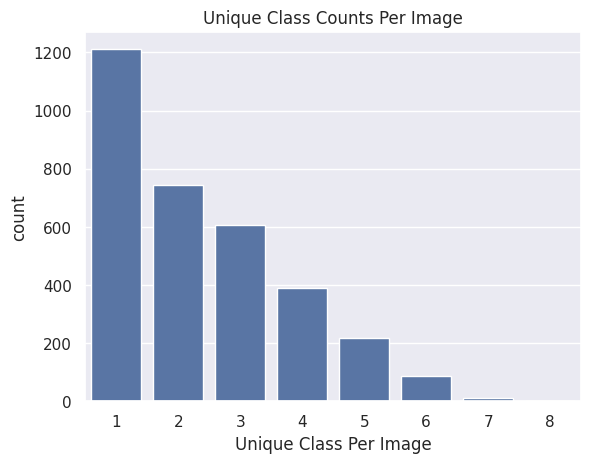

In [96]:
sns.barplot(x=class_count_df['class_num'].values.squeeze().tolist()[:8], y=class_count_df['count'].values.squeeze().tolist()[:8],  color='b')
plt.title('Unique Class Counts Per Image')
plt.xlabel('Unique Class Per Image')
plt.ylabel('count')

## 이미지 사이즈 대비 객체 (bbox) 크기  분포

In [460]:
bbox_size_list = []
small_object_image_list = []
small_object_ann_list = []
for i in range(len(anns)):
    ann = anns[i]
    width, height = ann['bbox'][2:]
    bbox_size_list.append(width*height)
    if width*height < 200:
        small_object_image_list.append(ann['image_id'])
        small_object_ann_list.append(ann['id'])

In [158]:
bbox_size_ratio_list = []
for i in range(len(bbox_size_list)):
    bbox_size_ratio_list.append(bbox_size_list[i]/(512*512))

(0.0, 0.5)

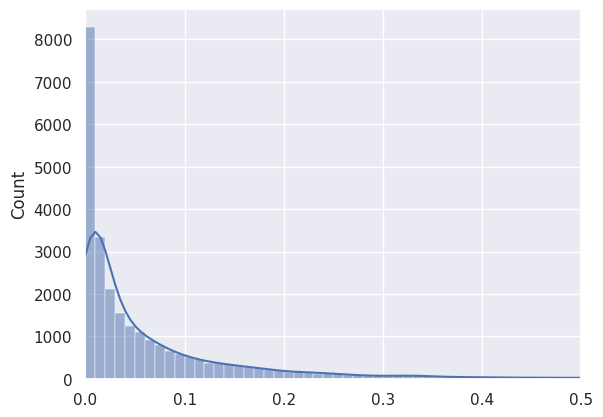

In [184]:
sns.histplot(x=bbox_size_ratio_list, bins=100, kde=True)
plt.xlim((0.0,0.5))

<AxesSubplot: ylabel='Count'>

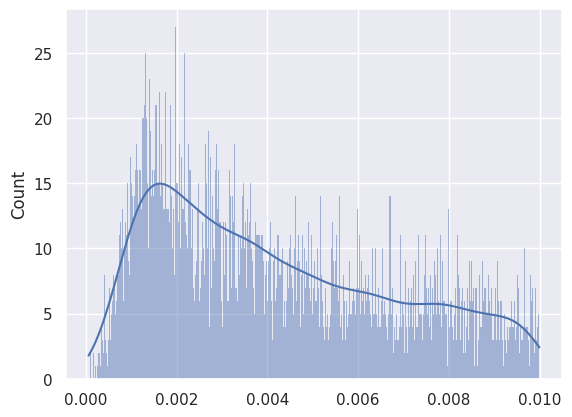

In [188]:
# 크기가 작은 box만, 상당히 작은 box가 다수 존재
sns.histplot(x=[i for i in bbox_size_ratio_list if i < 0.01], bins=1000, kde=True)
# plt.xlim((0.0,0.5))

## 각 Class 별, 이미지 사이즈 대비 객체 (bbox) 크기 분포

In [248]:
class_bbox_size_dict = {key:0 for key in categories_list}
class_bbox_num_dict = {key:0 for key in categories_list}
for i in range(len(anns)):
    ann = anns[i]
    category = categories_list[ann['category_id']-1]
    width, height = ann['bbox'][2:]
    class_bbox_size_dict[category] += (width*height)
    class_bbox_num_dict[category] += 1

In [249]:
# class별 bbox의 평균 사이즈
for cls in class_bbox_num_dict.keys():
    class_bbox_size_dict[cls] = (class_bbox_size_dict[cls] / class_bbox_num_dict[cls])/(512*512)

In [250]:
bbox_area_per_class = pd.DataFrame(class_bbox_size_dict.values(), index=class_bbox_size_dict.keys(), columns=['mean_area'])
bbox_area_per_class = bbox_area_per_class.sort_values(by='mean_area', ascending=False)

Text(0.5, 0, 'bbox size / img size')

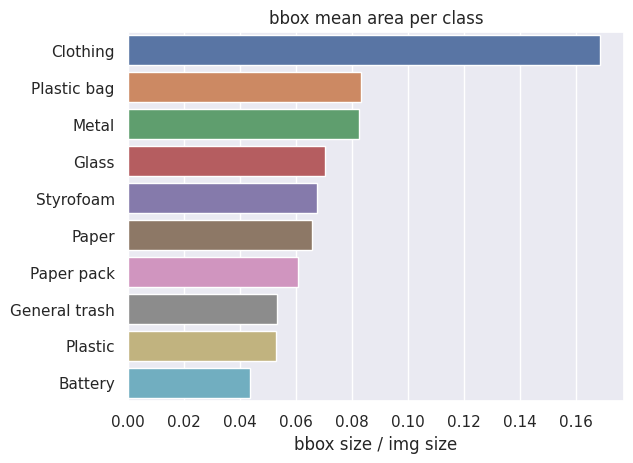

In [252]:
sns.barplot(y=list(bbox_area_per_class.index), x=list(bbox_area_per_class.values.squeeze()))
plt.title('bbox mean area per class')
plt.xlabel('bbox size / img size')

In [477]:
(384*384) / (512*512)

0.5625

In [473]:
max_width = 0
max_height = 0
for i in range(len(anns)):
    ann = anns[i]
    width, height = ann['bbox'][2:]
    if max_width < width:
        max_width=width
    if max_height < height:
        max_height=height
print(f'max height: {max_height}, max width: {max_width}')

max height: 511.9, max width: 511.9


## 객체 영역 크기(이미지 크기 대비 객체 영역 크기)

In [123]:
## 이미지 당 객체 영역의 비율 계산
object_pixel_count_per_img = {img_id:0 for img_id in range(len(imgs))}
img_size = 512*512
for i in range(len(anns)):
    ann = anns[i]
    for j in range(len(ann['segmentation'])):
        object_pixel_count_per_img[ann['image_id']] += len(ann['segmentation'][j])

In [124]:
for key in object_pixel_count_per_img.keys():
    object_pixel_count_per_img[key] = object_pixel_count_per_img[key]/(512*512)
object_ratio_df = pd.DataFrame(object_pixel_count_per_img.values(), columns=['ratio'])

In [129]:
# pd.options.display.float_format = '{:.5f}'.format

Text(0.5, 1.0, 'object area ratio')

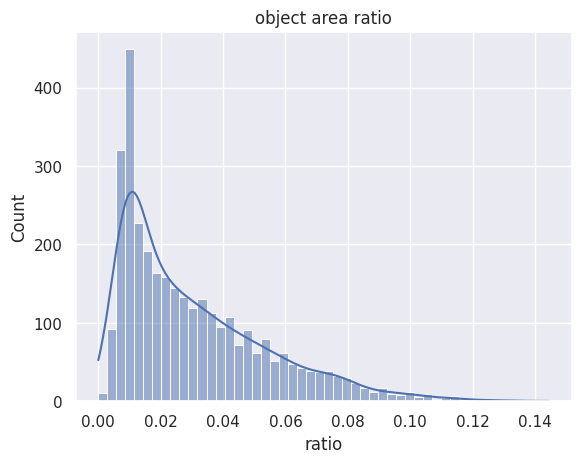

In [140]:
sns.histplot(data = object_ratio_df, x = 'ratio', bins=50, kde=True)
plt.title('object area ratio')

## 객체 중심 좌표 위치

In [198]:
categories_list = []
for i in categories:
    categories_list.append(i['name'])
categories_list

['General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [200]:
center_x_dict = {key:[] for key in range(1,11)}
center_y_dict = {key:[] for key in range(1,11)}
for i in range(len(anns)):
    ann = anns[i]
    x, y, width, height = ann['bbox']
    category_id = ann['category_id']
    center_x = x + width/2
    center_y = y + height/2
    center_x_dict[category_id].append(center_x)
    center_y_dict[category_id].append(center_y)

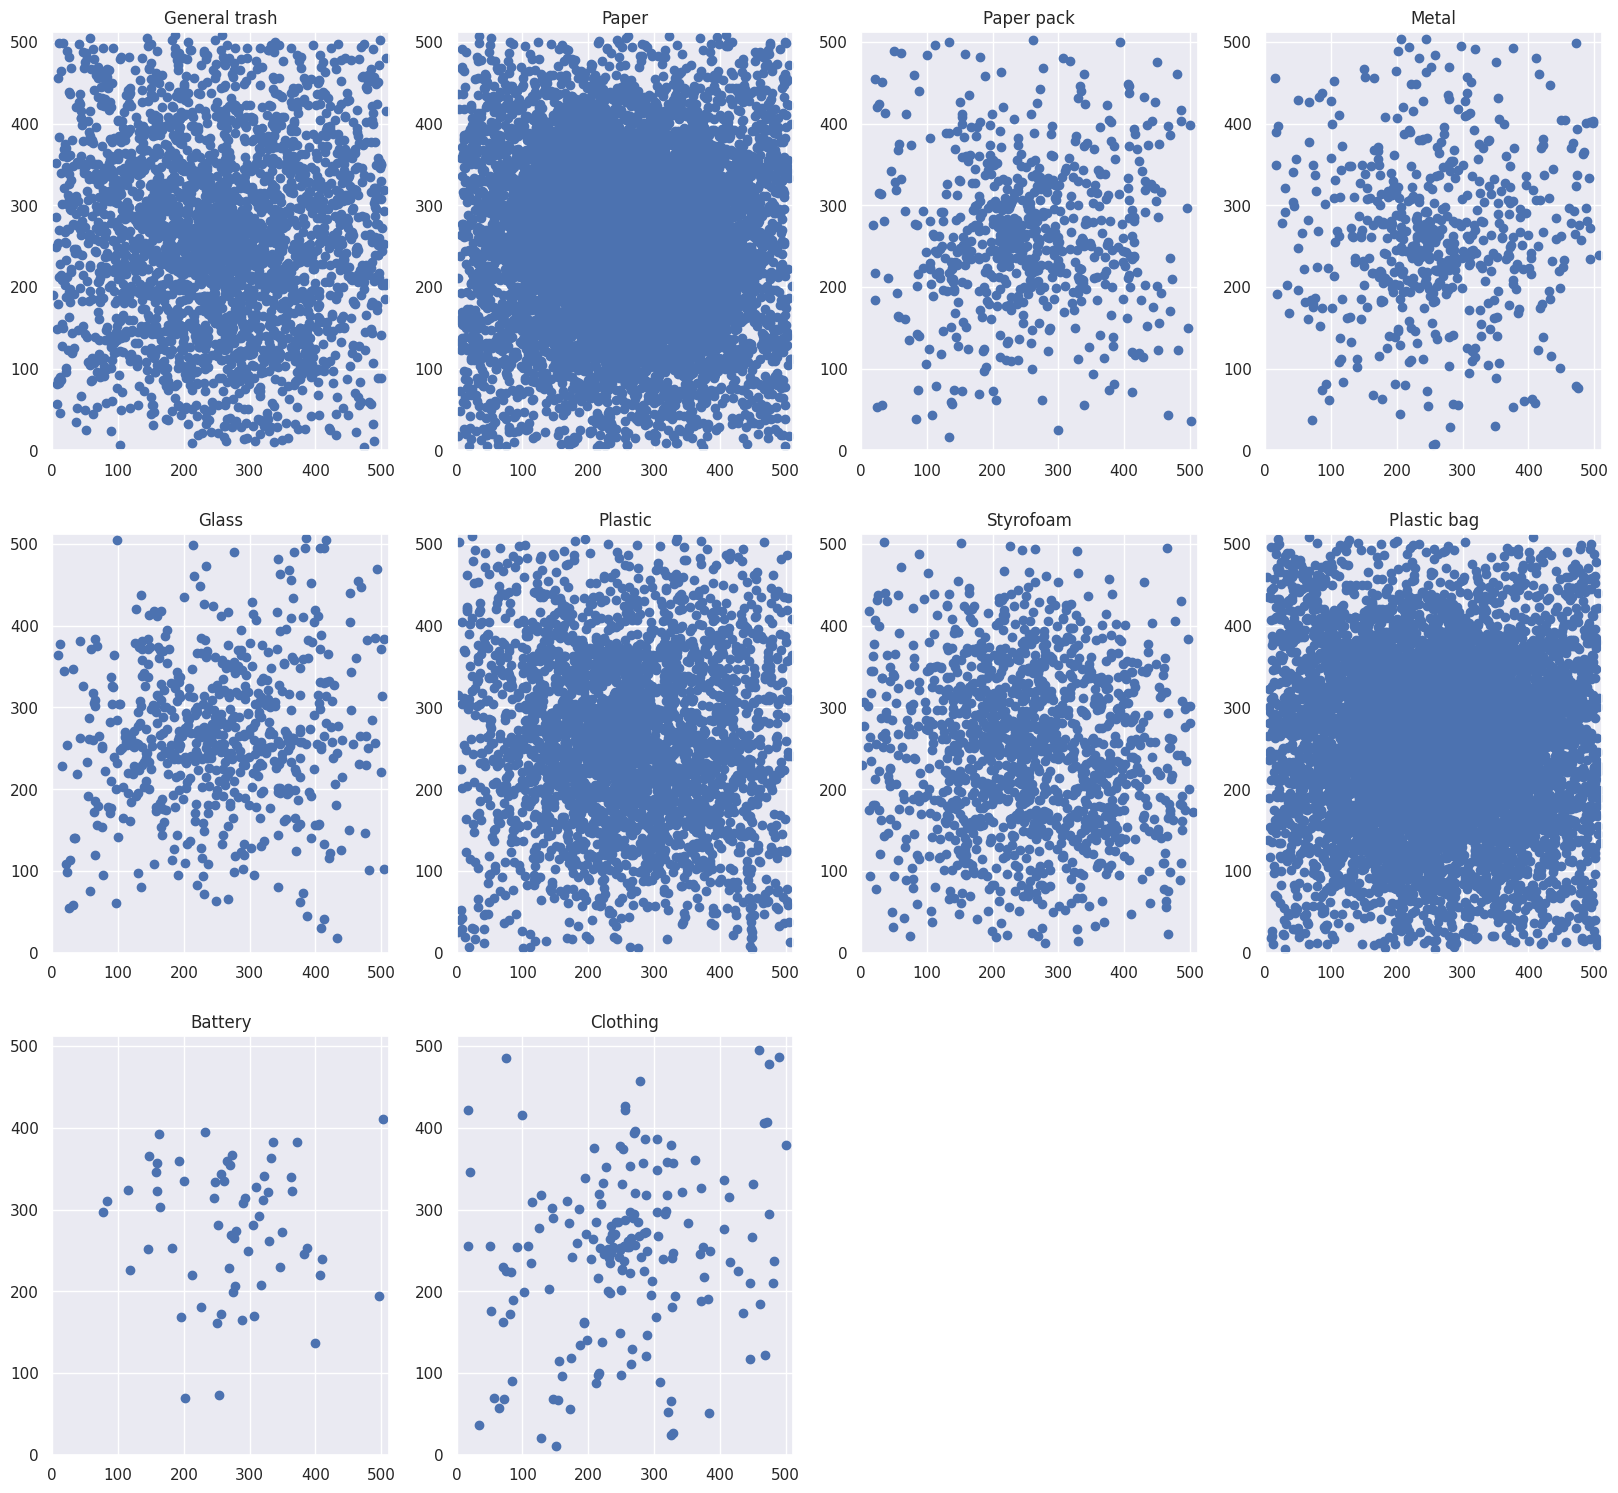

In [206]:
fig = plt.figure(figsize=(20,25))
for i, cls in enumerate(categories_list):
    plt.subplot(4, 4, i+1)
    plt.scatter(x=center_x_dict[i+1], y=center_y_dict[i+1])
    plt.title(cls)
    plt.xlim(0,512)
    plt.ylim(0,512)

## 굉장히 bbox작은(mask가 작은) 이미지 시각화 
- bbox의 크기(w*h)가 50미만인
- 노이즈로 판단해서 데이터 클렌징 할지, 아니면 finetuning 해볼지

In [323]:
small_object_image_path_list = []
for img in imgs:
    if img['id'] in small_object_image_list:
        small_object_image_path_list.append(img['file_name'])

In [298]:
categories_list.insert(0,'Background')

In [300]:
from torch.utils.data import Dataset, DataLoader
import torch

category_names = categories_list

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [304]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = './input/data/train_all.json'


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.48s)
creating index...
index created!


In [324]:
small_object_image_path_list

['batch_02_vt/0210.jpg',
 'batch_02_vt/0435.jpg',
 'batch_02_vt/1102.jpg',
 'batch_02_vt/1269.jpg',
 'batch_02_vt/1807.jpg',
 'batch_03/0061.jpg',
 'batch_03/0397.jpg']

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Background'}, {'Paper', 2}, {'Styrofoam', 7}, {8, 'Plastic bag'}]


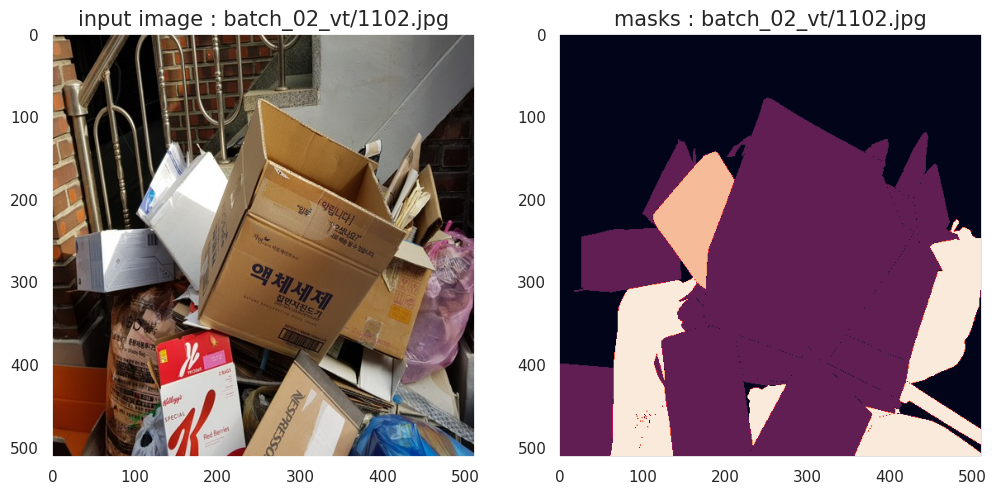

In [325]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    if image_infos['file_name'] == 'batch_02_vt/1102.jpg':
        temp_images = imgs
        temp_masks = masks
        break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [462]:
small_object_ann_list[:10]

[57, 409, 427, 428, 1156, 1590, 2230, 2238, 3956, 4103]

In [463]:
for ann in anns:
    if ann['id'] == 409: # ann id 입력
        masks = ann['segmentation']
        img_id = ann['image_id']
for img in imgs:
    if img['id'] == img_id:
        img_file_name = img['file_name']
seg_img = np.zeros((512,512))

In [464]:
for mask in masks:
    for x in range(0,len(mask),2):
        x_coord = mask[x]
        y_coord = mask[x+1]
        seg_img[y_coord][x_coord] = 1.0

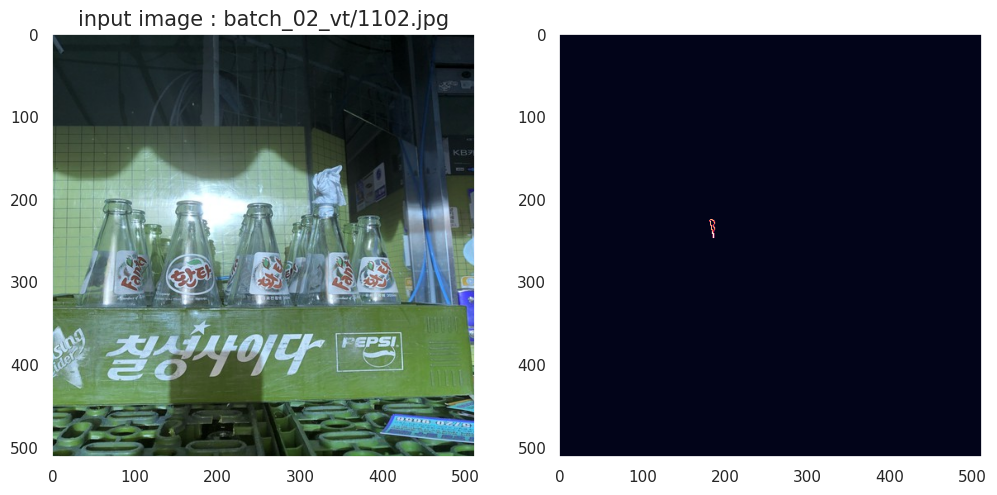

In [465]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
small_object_img = cv2.imread(os.path.join('./input/data',img_file_name))

ax1.imshow(small_object_img)
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(seg_img)
ax2.grid(False)

plt.show()

In [444]:
## 바운딩 박스 좌표 이용할 수 있나 -> 가능, 바운딩 박스로 하나의 객체로 잡히는 영역에 대해 segmentation 라벨링 진행하는듯

# 이미지당 class의 개수, 객체 크기(or 객체 영역 비율)로 multilabel stratified 하거나 그냥 stratified groupkfold

## train data의 mean, std 계산
- https://tw0226.tistory.com/20 참고

In [479]:
import cv2
import numpy as np
import glob
from tqdm import tqdm 

path = '/opt/ml/input/data/mmseg/images/train_MultiStfKFold' 
exts = ['.jpg', '.png', '.jpeg', '.bmp']

data_list = []
for ext in exts:
    data_list+=glob.glob(path+'/*'+ext)

img_norm = list()
img_std = list()

for data in tqdm(data_list, total=len(data_list)):
    img = cv2.imread(data, cv2.IMREAD_COLOR).astype(np.float32)
    mean,std = np.mean(img, axis=(0,1)), np.std(img, axis=(0,1))
    img_norm.append(mean)
    img_std.append(std)

print(np.mean(img_norm, axis=0), np.mean(img_std, axis=0))

100%|██████████| 2618/2618 [01:03<00:00, 41.36it/s]

[106.44883 111.83318 117.12853] [55.131298 52.915947 53.72297 ]


In [ ]:
[106.44883 111.83318 117.12853] [55.131298 52.915947 53.72297 ]